# 데이터 및 라이브러리 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os, gc, sys
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 30)

In [3]:
path = '/content/drive/MyDrive/kaggle/home_credit_default_risk'

In [4]:
def get_dataset():
  app_train = pd.read_csv(os.path.join(path, 'application_train.csv'))
  app_test = pd.read_csv(os.path.join(path, 'application_test.csv'))
  apps = pd.concat([app_train, app_test])

  prev = pd.read_csv(os.path.join(path, 'previous_application.csv'))

  bureau = pd.read_csv(os.path.join(path, 'bureau.csv'))
  bureau_bal = pd.read_csv(os.path.join(path, 'bureau_balance.csv'))

  return apps, prev, bureau, bureau_bal

apps, prev, bureau, bureau_bal = get_dataset()

# bureau, bureau_balance 칼럼 

|Table|컬럼명|컬럼 대분류|컬럼 중분류|컬럼 설명|
|------|--------|----|--------|-----------------|
|bureau.csv|SK_ID_CURR|대출|고유ID|현재 대출 고유 ID|
|bureau.csv|SK_BUREAU_ID|대출|고유ID|타 기관 대출 고유 ID|
|bureau.csv|CREDIT_ACTIVE|대출|대출 상태|대출 상태(Active: 대출 상환중, Closed: 상환 완료)|
|bureau.csv|CREDIT_CURRENCY|대출|대출 금액|대출 금액 화폐유형|
|bureau.csv|DAYS_CREDIT|대출|행동|현재 대출 신청 일 기준 과거 대출 신청 지난 기간|
|bureau.csv|CREDIT_DAY_OVERDUE|대출|행동|대출 신청 시 CB 크레딧 연체 일수|
|bureau.csv|DAYS_CREDIT_ENDDATE|대출|상태|CB 크레딧 채무 완료까지 남아있는 일수(신청일 기준)|
|bureau.csv|DAYS_ENDDATE_FACT|대출|상태|CB 크레딧 채무 완료까지 걸린 실제 일수(신청일 기준, 상태가 Close일때만)|
|bureau.csv|AMT_CREDIT_MAX_OVERDUE|대출|상태|최대 연체금액|
|bureau.csv|CNT_CREDIT_PROLONG|대출|상태|신용 연장 횟수|
|bureau.csv|AMT_CREDIT_SUM|대출|대출 금액|현재 크레딧 금액 총액|
|bureau.csv|AMT_CREDIT_SUM_DEBT|대출|대출 금액|현재 채무 금액 총액|
|bureau.csv|AMT_CREDIT_SUM_LIMIT|대출|대출 금액|신용 카드 현재 신용한도|
|bureau.csv|AMT_CREDIT_SUM_OVERDUE|대출|상태|현재 연체 금액|
|bureau.csv|CREDIT_TYPE|대출|대출 유형|크레딧 유형|
|bureau.csv|DAYS_CREDIT_UPDATE|대출|대출 행동|대출 신청전 마지막 정보 받은 기간|
|bureau.csv|AMT_ANNUITY|대출|대출 금액|월 대출 지급액|
|bureau_balance.csv|SK_BUREAU_ID|대출|고유ID|타 기관 대출 고유 ID|
|bureau_balance.csv|MONTHS_BALANCE|대출|상태|신청일 기준 잔액 월 |
|bureau_balance.csv|STATUS|대출|상태|월별 대출 상태(Active: 대출 상환중, Closed: 상환 완료, DPD0-30: 30일 이전 연체 상태등|


In [6]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [7]:
bureau.isnull().sum()

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

# TARGET 값에 따른 연속형 feature들의 Histogram

In [8]:
bureau_app = bureau.merge(apps[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

In [9]:
num_columns = bureau_app.dtypes[bureau_app.dtypes != 'object'].index.tolist()

num_columns = [column for column in num_columns if column not in['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']]

In [10]:
def show_hist_by_target(df, columns):
  cond_1 = (df['TARGET'] == 1)
  cond_0 = (df['TARGET'] == 0)

  for column in columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), squeeze= False)

    sns.violinplot(x='TARGET', y=column, data= df[np.isfinite(df[column])], ax=axes[0][0])
    sns.distplot(df[cond_0 & np.isfinite(df[column])][column], label='0', color='blue', ax=axes[0][1])
    sns.distplot(df[cond_1 & np.isfinite(df[column])][column], label='1', color='red', ax=axes[0][1] )

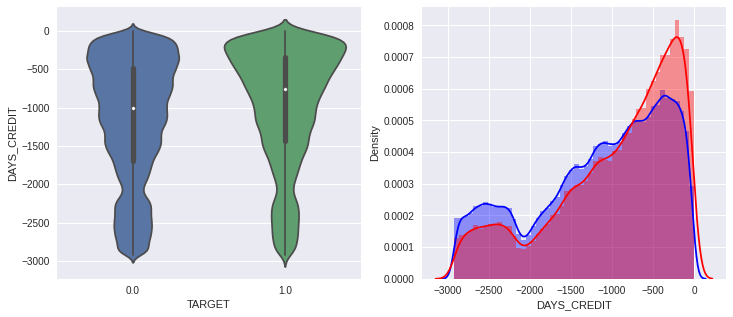

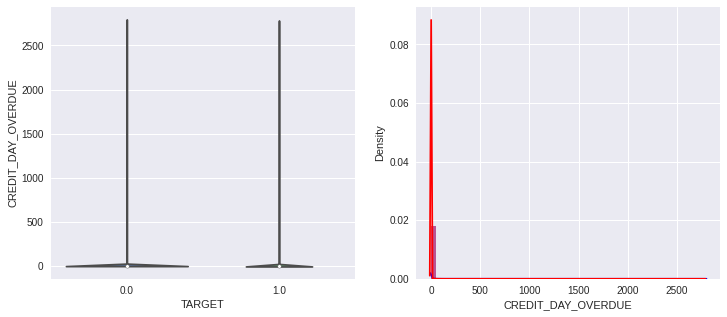

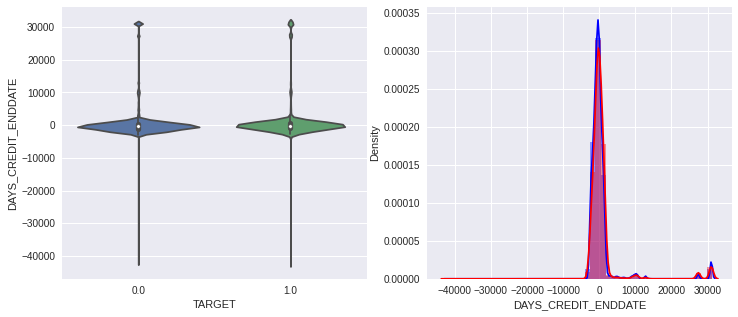

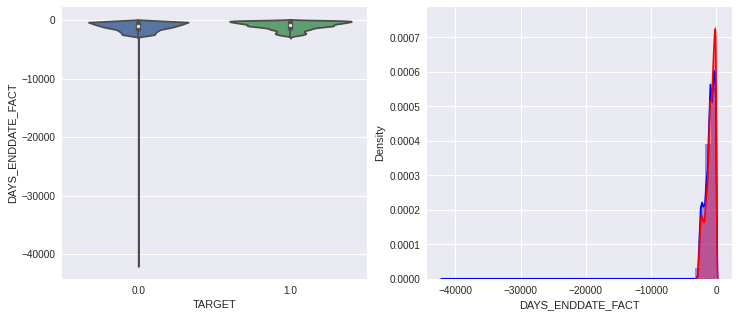

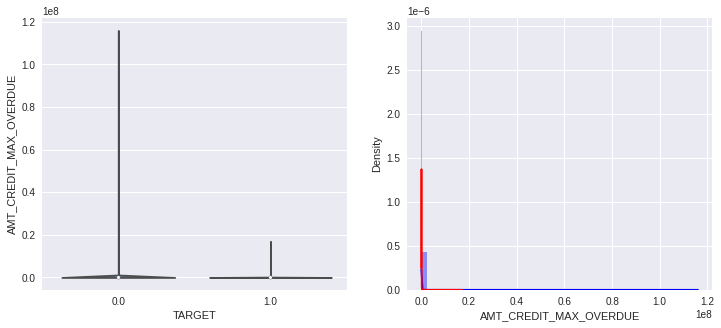

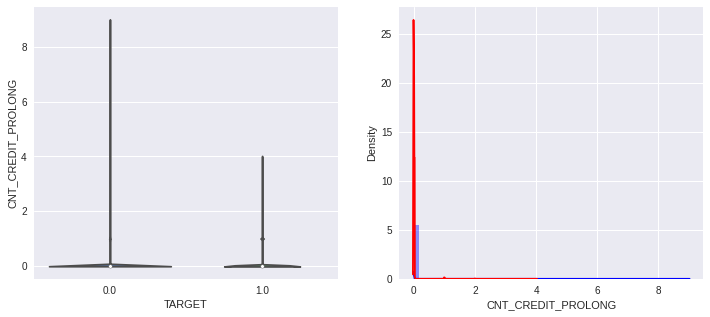

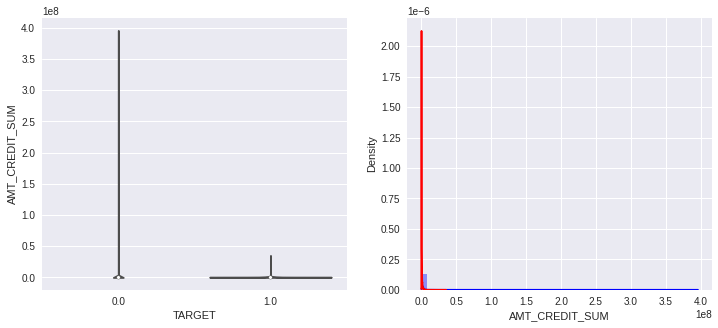

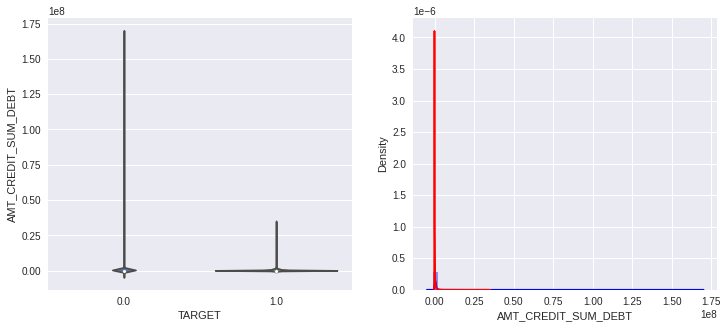

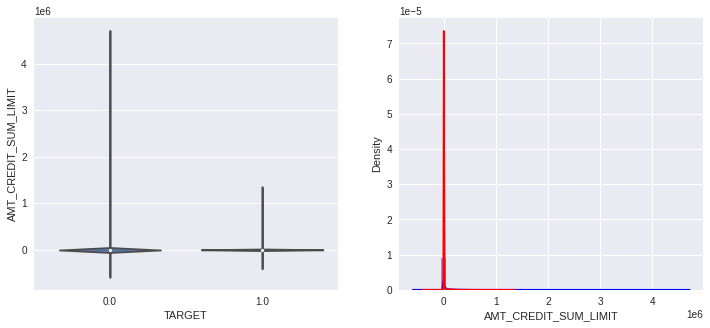

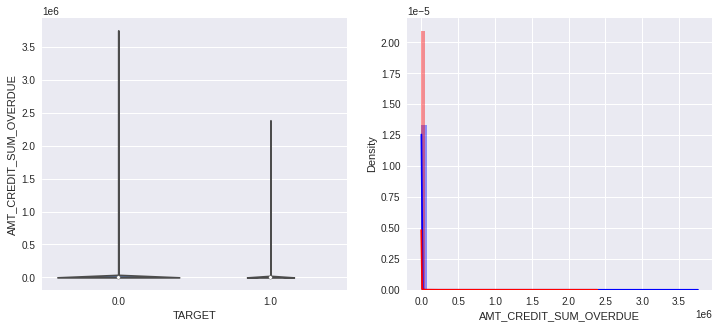

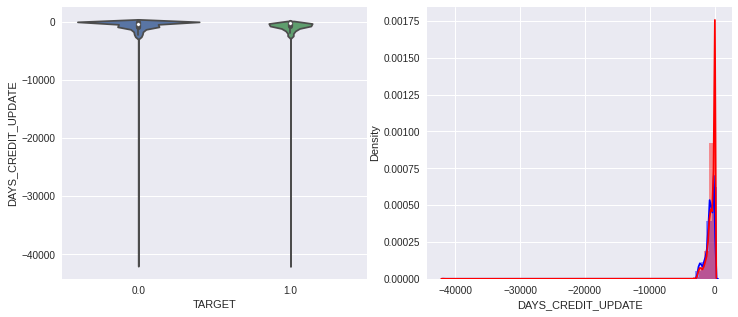

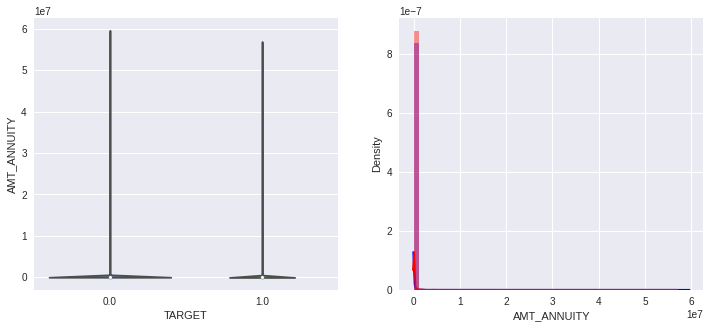

In [11]:
show_hist_by_target(bureau_app, num_columns)

# TARGET 값에 따른 카테고리형 feature Histogram

In [15]:
object_columns = bureau.dtypes[bureau.dtypes == 'object'].index.tolist()

In [16]:
def show_categroy_by_target(df, columns):
  for column in columns:
    chart = sns.catplot(x=column, col='TARGET', data=df, kind='count')
    chart.set_xticklabels(rotation=60)

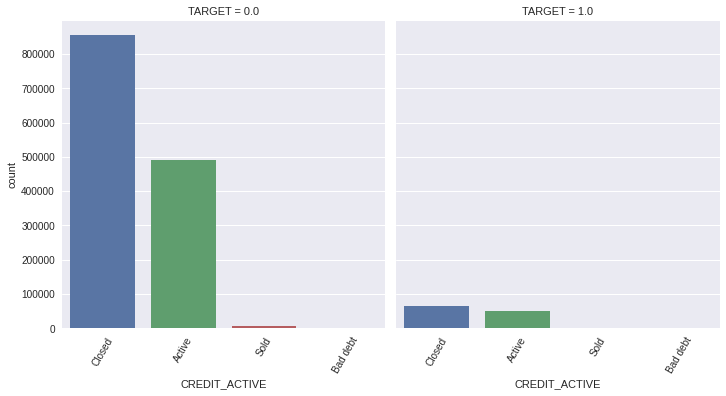

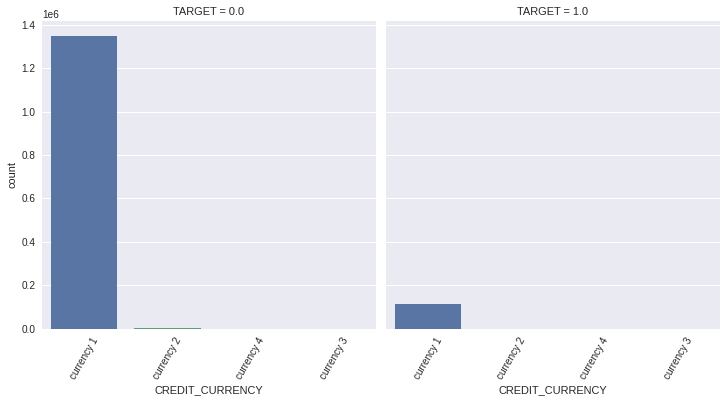

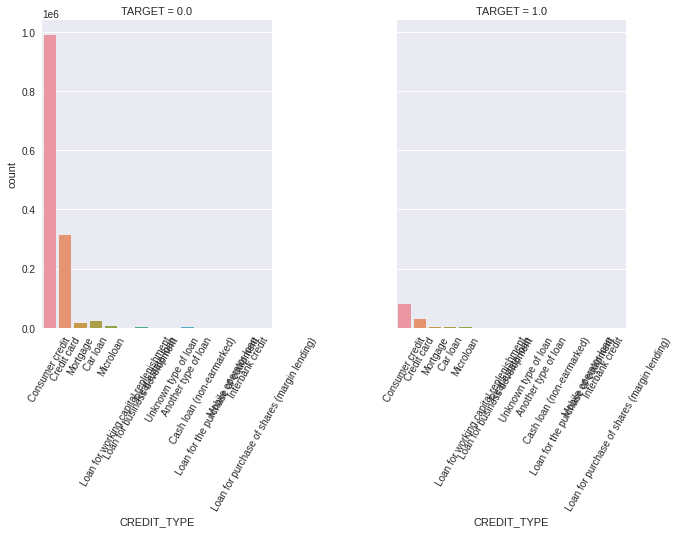

In [17]:
show_categroy_by_target(bureau_app, object_columns)

# Feature engineering

## bureau 데이터

### bureau 채무 완료 날짜 및 대출 금액 대비 채무금액 

In [19]:
# 예정 채무 시작 및 완료일과 실제 채무 완료일간의 차이 및 날짜 비율 가공
bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']

# 채무 금액 대비/대출 금액 비율 및 차이 가공
bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']

In [20]:
bureau['AMT_CREDIT_SUM_DEBT'].value_counts().head(30)

 0.0          1016434
 4.5              653
-450.0            543
 135000.0         344
 90000.0          320
 45000.0          316
 22500.0          307
 67500.0          238
 225000.0         237
 13500.0          205
 450000.0         177
 112500.0         156
 18000.0          143
 157500.0         139
 27000.0          132
 54000.0          125
 9000.0           121
 270000.0         107
 22950.0          101
 900000.0          98
 675000.0          97
 180000.0          97
 9.0               94
 225.0             88
-45.0              84
 31500.0           84
 36000.0           81
 450.0             81
 1350000.0         81
 49500.0           81
Name: AMT_CREDIT_SUM_DEBT, dtype: int64

### CREDIT_DAY_OVERDUE (연체 일수)

In [21]:
bureau['CREDIT_DAY_OVERDUE'].value_counts()

0       1712211
30          311
60          126
13          103
8           103
         ...   
1548          1
1546          1
519           1
2565          1
372           1
Name: CREDIT_DAY_OVERDUE, Length: 942, dtype: int64

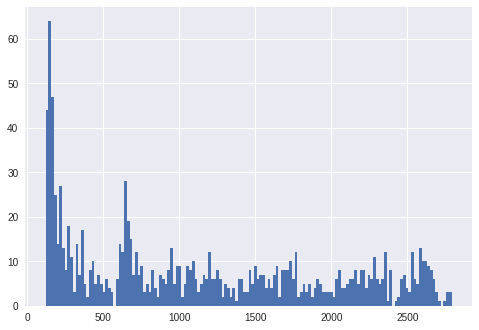

In [23]:
bureau[bureau['CREDIT_DAY_OVERDUE'] > 120]['CREDIT_DAY_OVERDUE'].hist(bins=150)

연체일수 120일 이상 여부 칼럼 가공

In [24]:
bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
bureau['BUREAU_IS_DPD'].value_counts()

0    1712211
1       4217
Name: BUREAU_IS_DPD, dtype: int64

In [26]:
bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x>120 else 0)
bureau['BUREAU_IS_DPD_OVER120'].value_counts()

0    1715285
1       1143
Name: BUREAU_IS_DPD_OVER120, dtype: int64

주요 피쳐들 가공 컬럼으로 agg 생성

In [27]:
bureau_agg_dict = {
    # 기존 컬럼
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],
    # 추가 가공 컬럼
    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
}

bureau_group = bureau.groupby('SK_ID_CURR')
bureau_day_amt_agg = bureau_group.agg(bureau_agg_dict)

# 칼럼명
bureau_day_amt_agg.columns = ['BUREAU_' + '_'.join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]

# reset index
bureau_day_amt_agg = bureau_day_amt_agg.reset_index()

In [28]:
bureau_day_amt_agg.head()

,SK_ID_CURR,BUREAU_SK_ID_BUREAU_COUNT,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_ENDDATE_FACT_MIN,BUREAU_DAYS_ENDDATE_FACT_MAX,BUREAU_DAYS_ENDDATE_FACT_MEAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_SUM,BUREAU_BUREAU_ENDDATE_FACT_DIFF_MIN,BUREAU_BUREAU_ENDDATE_FACT_DIFF_MAX,BUREAU_BUREAU_ENDDATE_FACT_DIFF_MEAN,BUREAU_BUREAU_CREDIT_FACT_DIFF_MIN,BUREAU_BUREAU_CREDIT_FACT_DIFF_MAX,BUREAU_BUREAU_CREDIT_FACT_DIFF_MEAN,BUREAU_BUREAU_CREDIT_ENDDATE_DIFF_MIN,BUREAU_BUREAU_CREDIT_ENDDATE_DIFF_MAX,BUREAU_BUREAU_CREDIT_ENDDATE_DIFF_MEAN,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MIN,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MAX,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,BUREAU_BUREAU_CREDIT_DEBT_DIFF_MIN,BUREAU_BUREAU_CREDIT_DEBT_DIFF_MAX,BUREAU_BUREAU_CREDIT_DEBT_DIFF_MEAN,BUREAU_BUREAU_IS_DPD_MEAN,BUREAU_BUREAU_IS_DPD_SUM,BUREAU_BUREAU_IS_DPD_OVER120_MEAN,BUREAU_BUREAU_IS_DPD_OVER120_SUM
0,100001,7,-1572,-49,-735.000000,0,0,0.0,-1329.0,1778.0,82.428571,-1328.0,-544.0,-825.500000,NaN,NaN,378000.0,207623.571429,1453365.000,373239.0,85240.928571,596686.5,0.0,0.0,0.0,10822.5,3545.357143,24817.5,-1.0,698.0,197.0,-335.0,-32.0,-228.750000,-1827.0,-243.0,-817.428571,0.0,0.987405,0.282518,-279720.0,-4761.0,-122382.642857,0.0,0,0.0,0
1,100002,8,-1437,-103,-874.000000,0,0,0.0,-1072.0,780.0,-349.000000,-1185.0,-36.0,-697.500000,5043.645,1681.029,450000.0,108131.945625,865055.565,245781.0,49156.200000,245781.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1029.0,252.6,-609.0,-76.0,-277.000000,-1822.0,-87.0,-719.833333,0.0,0.546180,0.136545,-204219.0,0.0,-98388.513000,0.0,0,0.0,0
2,100003,4,-2586,-606,-1400.750000,0,0,0.0,-2434.0,1216.0,-544.500000,-2131.0,-540.0,-1097.333333,0.000,0.000,810000.0,254350.125000,1017400.500,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,0.0,-303.0,201.0,-34.0,-1096.0,-154.0,-568.333333,-1822.0,-152.0,-856.250000,0.0,0.000000,0.000000,-810000.0,-22248.0,-254350.125000,0.0,0,0.0,0
3,100004,2,-1326,-408,-867.000000,0,0,0.0,-595.0,-382.0,-488.500000,-683.0,-382.0,-532.500000,0.000,0.000,94537.8,94518.900000,189037.800,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,88.0,44.0,-643.0,-26.0,-334.500000,-731.0,-26.0,-378.500000,0.0,0.000000,0.000000,-94537.8,-94500.0,-94518.900000,0.0,0,0.0,0
4,100005,3,-373,-62,-190.666667,0,0,0.0,-128.0,1324.0,439.333333,-123.0,-123.0,-123.000000,0.000,0.000,568800.0,219042.000000,657126.000,543087.0,189469.500000,568408.5,0.0,0.0,0.0,4261.5,1420.500000,4261.5,-5.0,-5.0,-5.0,-250.0,-250.0,-250.000000,-1461.0,-184.0,-630.000000,0.0,0.954794,0.601256,-58500.0,-4504.5,-29572.500000,0.0,0,0.0,0


### 현재 대출 중 Active인 상태만 Groupby

In [30]:
cond_active = bureau['CREDIT_ACTIVE'] == 'Active'

bureau_active_grp = bureau[cond_active].groupby('SK_ID_CURR')
bureau_agg_dict = {
    # 기존 컬럼
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],
    # 추가 가공 컬럼
    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }

bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)

# 컬럼명
bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]

# reset_index
bureau_active_agg = bureau_active_agg.reset_index()

In [32]:
bureau_active_agg.head(5)

,SK_ID_CURR,BUREAU_ACT_SK_ID_BUREAU_COUNT,BUREAU_ACT_DAYS_CREDIT_MIN,BUREAU_ACT_DAYS_CREDIT_MAX,BUREAU_ACT_DAYS_CREDIT_MEAN,BUREAU_ACT_CREDIT_DAY_OVERDUE_MIN,BUREAU_ACT_CREDIT_DAY_OVERDUE_MAX,BUREAU_ACT_CREDIT_DAY_OVERDUE_MEAN,BUREAU_ACT_DAYS_CREDIT_ENDDATE_MIN,BUREAU_ACT_DAYS_CREDIT_ENDDATE_MAX,BUREAU_ACT_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_ACT_DAYS_ENDDATE_FACT_MIN,BUREAU_ACT_DAYS_ENDDATE_FACT_MAX,BUREAU_ACT_DAYS_ENDDATE_FACT_MEAN,BUREAU_ACT_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_ACT_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_ACT_AMT_CREDIT_SUM_MAX,BUREAU_ACT_AMT_CREDIT_SUM_MEAN,BUREAU_ACT_AMT_CREDIT_SUM_SUM,BUREAU_ACT_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_ACT_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_ACT_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_ACT_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_ACT_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_ACT_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_ACT_AMT_ANNUITY_MAX,BUREAU_ACT_AMT_ANNUITY_MEAN,BUREAU_ACT_AMT_ANNUITY_SUM,BUREAU_ACT_BUREAU_ENDDATE_FACT_DIFF_MIN,BUREAU_ACT_BUREAU_ENDDATE_FACT_DIFF_MAX,BUREAU_ACT_BUREAU_ENDDATE_FACT_DIFF_MEAN,BUREAU_ACT_BUREAU_CREDIT_FACT_DIFF_MIN,BUREAU_ACT_BUREAU_CREDIT_FACT_DIFF_MAX,BUREAU_ACT_BUREAU_CREDIT_FACT_DIFF_MEAN,BUREAU_ACT_BUREAU_CREDIT_ENDDATE_DIFF_MIN,BUREAU_ACT_BUREAU_CREDIT_ENDDATE_DIFF_MAX,BUREAU_ACT_BUREAU_CREDIT_ENDDATE_DIFF_MEAN,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MIN,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MEAN,BUREAU_ACT_BUREAU_CREDIT_DEBT_DIFF_MIN,BUREAU_ACT_BUREAU_CREDIT_DEBT_DIFF_MAX,BUREAU_ACT_BUREAU_CREDIT_DEBT_DIFF_MEAN,BUREAU_ACT_BUREAU_IS_DPD_MEAN,BUREAU_ACT_BUREAU_IS_DPD_SUM,BUREAU_ACT_BUREAU_IS_DPD_OVER120_MEAN,BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM
0,100001,3,-559,-49,-309.333333,0,0,0.0,411.0,1778.0,1030.333333,NaN,NaN,NaN,NaN,NaN,378000.0,294675.0000,884025.000,373239.0,198895.50,596686.5,0.0,0.0,0.0,10822.5,8272.50,24817.5,NaN,NaN,NaN,NaN,NaN,NaN,-1827.0,-731.0,-1339.666667,0.335128,0.987405,0.659208,-224514.0,-4761.000,-95779.5000,0.0,0,0.0,0
1,100002,2,-1042,-103,-572.500000,0,0,0.0,780.0,780.0,780.000000,NaN,NaN,NaN,40.5,40.5,450000.0,240994.2825,481988.565,245781.0,122890.50,245781.0,0.0,0.0,0.0,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-1822.0,-1822.0,-1822.000000,0.000000,0.546180,0.273090,-204219.0,-31988.565,-118103.7825,0.0,0,0.0,0
2,100003,1,-606,-606,-606.000000,0,0,0.0,1216.0,1216.0,1216.000000,NaN,NaN,NaN,0.0,0.0,810000.0,810000.0000,810000.000,0.0,0.00,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-1822.0,-1822.0,-1822.000000,0.000000,0.000000,0.000000,-810000.0,-810000.000,-810000.0000,0.0,0,0.0,0
3,100005,2,-137,-62,-99.500000,0,0,0.0,122.0,1324.0,723.000000,NaN,NaN,NaN,0.0,0.0,568800.0,299313.0000,598626.000,543087.0,284204.25,568408.5,0.0,0.0,0.0,4261.5,2130.75,4261.5,NaN,NaN,NaN,NaN,NaN,NaN,-1461.0,-184.0,-822.500000,0.848974,0.954794,0.901884,-25713.0,-4504.500,-15108.7500,0.0,0,0.0,0
4,100008,1,-78,-78,-78.000000,0,0,0.0,471.0,471.0,471.000000,NaN,NaN,NaN,0.0,0.0,267606.0,267606.0000,267606.000,240057.0,240057.00,240057.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-549.0,-549.0,-549.000000,0.897054,0.897054,0.897054,-27549.0,-27549.000,-27549.0000,0.0,0,0.0,0


In [33]:
bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')

### SK_ID_CURR 별 건수 대비 연체 건수 비율 

In [34]:
select_columns = ['SK_ID_CURR', 'BUREAU_SK_ID_BUREAU_COUNT', 'BUREAU_BUREAU_IS_DPD_SUM', 'BUREAU_BUREAU_IS_DPD_OVER120_SUM',
                 'BUREAU_ACT_BUREAU_IS_DPD_SUM', 'BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']

In [35]:
bureau_agg['BUREAU_BUREAU_IS_DPD_SUM'].value_counts()

0    301947
1      3615
2       186
3        39
4        13
5         6
6         4
7         1
Name: BUREAU_BUREAU_IS_DPD_SUM, dtype: int64

In [36]:
# SK_ID_CURR 레벨로 DPD 비율, DPD > 120 비율 확률, Active 상태에서 DPD 비율, DPD > 120 비율 확률
bureau_agg['BUREAU_IS_DPD_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
bureau_agg['BUREAU_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
bureau_agg['BUREAU_ACT_IS_DPD_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
bureau_agg['BUREAU_ACT_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']

## bureau-balance 데이터

In [37]:
# 데이터 세트 재로딩. 
apps, prev, bureau, bureau_bal = get_dataset()

In [38]:
print(bureau_bal.shape, bureau.shape)

# bureau_bal과 bureau join
bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')
bureau_bal.shape

(27299925, 3) (1716428, 17)


(27299925, 4)

STATUS 에 따른 연체 값 가공

In [39]:
bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in['1','2','3','4','5']  else 0)
bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x =='5'  else 0)

In [40]:
bureau_bal['BUREAU_BAL_IS_DPD'].value_counts()

0    26956982
1      342943
Name: BUREAU_BAL_IS_DPD, dtype: int64

In [41]:
bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')

bureau_bal_agg_dict = {
    'SK_ID_CURR':['count'],
    'MONTHS_BALANCE':['min', 'max', 'mean'],
    'BUREAU_BAL_IS_DPD':['mean', 'sum'],
    'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']
}

bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)

# 컬럼명 
bureau_bal_agg.columns = [ 'BUREAU_BAL_'+('_').join(column).upper() for column in bureau_bal_agg.columns.ravel() ]

# reset_index
bureau_bal_agg = bureau_bal_agg.reset_index()

SK_ID_CURR에 따른 DPD 비율 , DPD 120일 이상 비율 컬럼 생성

In [42]:
bureau_bal_agg['BUREAU_BAL_IS_DPD_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']
bureau_bal_agg['BUREAU_BAL_IS_DPD_OVER120_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']

In [43]:
bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')

# Feature Engineering 함수화

In [44]:
# bureau 채무 완료 날짜 및 대출 금액 대비 채무 금액 관련 컬럼 가공
def get_bureau_processed(bureau):
    # 예정 채무 시작 및 완료일과 실제 채무 완료일간의 차이 및 날짜 비율 가공.  
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
  
    # 채무 금액 대비/대출 금액 비율 및 차이 가공
    bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    #bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']

    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)
    
    return bureau

# bureau 주요 컬럼 및 앞에서 채무 및 대출금액 관련 컬럼들로 SK_ID_CURR 레벨의 aggregation 컬럼 생성.
def get_bureau_day_amt_agg(bureau):
        
    bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],
    # 추가 가공 컬럼
    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_grp = bureau.groupby('SK_ID_CURR')
    bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
    bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
    print('bureau_day_amt_agg shape:', bureau_day_amt_agg.shape)
    return bureau_day_amt_agg

# Bureau의 CREDIT_ACTIVE='Active' 인 데이터만 filtering 후 주요 컬럼 및 앞에서 채무 및 대출금액 관련 컬럼들로 SK_ID_CURR 레벨의 aggregation 컬럼 생성
def get_bureau_active_agg(bureau):
    # CREDIT_ACTIVE='Active' 인 데이터만 filtering
    cond_active = bureau['CREDIT_ACTIVE'] == 'Active'
    bureau_active_grp = bureau[cond_active].groupby(['SK_ID_CURR'])
    bureau_agg_dict = {
        'SK_ID_BUREAU':['count'],
        'DAYS_CREDIT':['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        # 추가 가공 컬럼
        'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
        'BUREAU_IS_DPD':['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120':['mean', 'sum']
        }

    bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
    bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_active_agg = bureau_active_agg.reset_index()
    print('bureau_active_agg shape:', bureau_active_agg.shape)
    return bureau_active_agg

# bureau_bal을 SK_ID_CURR 레벨로 건수와 MONTHS_BALANCE의 aggregation 가공 
def get_bureau_bal_agg(bureau, bureau_bal):
    
    bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')
    bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in['1','2','3','4','5']  else 0)
    bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x =='5'  else 0)
    bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')
    # SK_ID_CURR 레벨로 건수와 MONTHS_BALANCE의 aggregation 가공 
    bureau_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'MONTHS_BALANCE':['min', 'max', 'mean'],
        'BUREAU_BAL_IS_DPD':['mean', 'sum'],
        'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)
    bureau_bal_agg.columns = [ 'BUREAU_BAL_'+('_').join(column).upper() for column in bureau_bal_agg.columns.ravel() ]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_bal_agg = bureau_bal_agg.reset_index()
    print('bureau_bal_agg shape:', bureau_bal_agg.shape)
    return bureau_bal_agg
    
# 가공된 bureau관련 aggregation 컬럼들을 모두 결합   
def get_bureau_agg(bureau, bureau_bal):
    
    bureau = get_bureau_processed(bureau)
    bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)
    bureau_active_agg = get_bureau_active_agg(bureau)
    bureau_bal_agg = get_bureau_bal_agg(bureau, bureau_bal)
    # 가공된 bureau관련 aggregation 컬럼들을 모두 조인하여 결합 후 return  
    bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
    bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')
    print('bureau_agg shape:', bureau_agg.shape)
    
    return bureau_agg

In [45]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

def get_apps_processed(apps):
    
    # EXT_SOURCE_X FEATURE 가공
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

def get_prev_processed(prev):
    # 대출 신청 금액과 실제 대출액/대출 상품금액 차이 및 비율
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']
    
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # 첫번째 만기일과 마지막 만기일까지의 기간
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    # 매월 납부 금액과 납부 횟수 곱해서 전체 납부 금액 구함. 
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    # 전체 납부 금액 대비 AMT_CREDIT 비율을 구하고 여기에 다시 납부횟수로 나누어서 이자율 계산. 
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
        
    return prev
    
    
def get_prev_amt_agg(prev):
    # 새롭게 생성된 대출 신청액 대비 다른 금액 차이 및 비율로 aggregation 수행. 
    agg_dict = {
         # 기존 컬럼 aggregation. 
        'SK_ID_CURR':['count'],
        'AMT_CREDIT':['mean', 'max', 'sum'],
        'AMT_ANNUITY':['mean', 'max', 'sum'], 
        'AMT_APPLICATION':['mean', 'max', 'sum'],
        'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
        'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        # 가공 컬럼 aggregation
        'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
        'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
        'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO':['mean', 'max'],
        'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
        'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

    # multi index 컬럼을 '_'로 연결하여 컬럼명 변경
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]
    
    return prev_amt_agg

def get_prev_refused_appr_agg(prev):
    # 원래 groupby 컬럼 + 세부 기준 컬럼으로 groupby 수행. 세분화된 레벨로 aggregation 수행 한 뒤에 unstack()으로 컬럼레벨로 변형. 
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
    # 컬럼명 변경. 
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
    # NaN값은 모두 0으로 변경. 
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
    
    return prev_refused_appr_agg

def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    
    # prev_amt_agg와 조인. 
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성. 
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

def get_apps_all_with_prev_agg(apps, prev):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all

def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all

def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]

    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test
    
def train_apps_all(apps_all_train):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
                nthread=4,
                n_estimators=2000,
                learning_rate=0.02,
                max_depth = 11,
                num_leaves=58,
                colsample_bytree=0.613,
                subsample=0.708,
                max_bin=407,
                reg_alpha=3.564,
                reg_lambda=4.930,
                min_child_weight= 6,
                min_child_samples=165,
                silent=-1,
                verbose=-1,
                )
   
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 200)
    
    return clf

데이터 결합

In [46]:
def get_apps_all_with_prev_bureau_agg(apps, prev, bureau, bureau_bal):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    bureau_agg = get_bureau_agg(bureau, bureau_bal)

    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(bureau_agg, on='SK_ID_CURR', how='left')

    return apps_all

# 데이터들 가공, 인코딩, 학습/테스트 데이터 분리, 학습

In [47]:
apps, prev, bureau, bureau_bal = get_dataset()

# application, previous, bureau, bureau_bal 관련 데이터셋 가공 및 취합
apps_all = get_apps_all_with_prev_bureau_agg(apps, prev, bureau, bureau_bal)

# Category 컬럼을 모두 Label 인코딩 수행
apps_all = get_apps_all_encoded(apps_all)

# 학습과 테스트 데이터로 분리
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)

#학습수행
clf = train_apps_all(apps_all_train)

bureau_day_amt_agg shape: (305811, 47)
bureau_active_agg shape: (251815, 47)
bureau_bal_agg shape: (134542, 9)
bureau_agg shape: (305811, 101)
train shape: (215257, 274) valid shape: (92254, 274)
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.241351	training's auc: 0.786455	valid_1's binary_logloss: 0.246882	valid_1's auc: 0.762927
[200]	training's binary_logloss: 0.230971	training's auc: 0.809212	valid_1's binary_logloss: 0.241643	valid_1's auc: 0.773873
[300]	training's binary_logloss: 0.224043	training's auc: 0.826349	valid_1's binary_logloss: 0.239554	valid_1's auc: 0.779481
[400]	training's binary_logloss: 0.218394	training's auc: 0.840568	valid_1's binary_logloss: 0.238581	valid_1's auc: 0.782014
[500]	training's binary_logloss: 0.213348	training's auc: 0.853174	valid_1's binary_logloss: 0.237941	valid_1's auc: 0.783771
[600]	training's binary_logloss: 0.208852	training's auc: 0.864056	valid_1's binary_logloss: 0.237544	valid_1's

In [48]:
preds = clf.predict_proba(apps_all_test.drop(['SK_ID_CURR'], axis=1))[:, 1]
apps_all_test['TARGET'] = preds

apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(path, 'bureau_baseline_01.csv'), index=False)